# Decorrelating tiny color cat pics

In some image analysis applications, specially when working with images of the color and tiny type, it is frequently interesting to apply some kind of whitening to the data before e.g. training a classifier.

I usually think of whitening as "removing the easy part" of the problem. Take away the mean, and decorrelate the data (remove linear dependencies). What is left? Whatever is left is what we want the "fancy" models to learn. The linar part is too easy, even I can do it! You don't need deep learning to decorrelate a cat picture.

The winteing technique called ZCA is frequently used in signal analysis, and relates to the Laplacian filter. I hope I can convince you of that in this Kernel. We'll just take a look at the ZCA of the CIFAR-10 images. We're basically going to reproduce the notorious work by Alex Krizhevsky on this dataset, and then finally explore the idea of the ZCA as a small linear filter that is applied to the image.

## Data input
We start by just reading the input and checking if it makes sense.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
%matplotlib inline   
plt.rcParams['image.cmap'] = 'gray'

In [2]:
def extract_frames(file_path, start_frame, n_frames, frame_rate=1):
    cap = cv2.VideoCapture(file_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return None
    frames = []
    for i in tqdm(range(start_frame+n_frames)):
        ret, frame = cap.read()
        if not ret:
            print("Video is over")
            break
        if i < start_frame or i % frame_rate != 0:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)[:, int(1280/2 - 720/2): int(1280/2 + 720/2)]
        for _ in range(2):
            frame = cv2.pyrDown(frame)
        frames.append(frame)
    cap.release()

    frames_array = np.array(frames)
    return frames_array

In [3]:
dd = extract_frames("forest_video.mp4", 1000, 512_000, 2)
total_components = np.prod(dd.shape[1:])
print("Data shape: ", dd.shape)

 53%|█████▎    | 271259/513000 [06:49<06:05, 661.64it/s]


Video is over
Data shape:  (135130, 180, 180)


In [5]:
np.save("extracted.npy", dd)

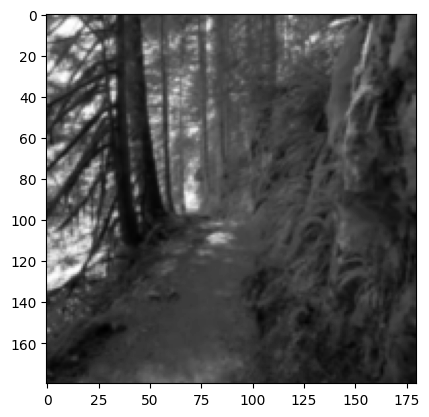

In [4]:
plt.imshow(dd[3000])

In [6]:
def slice_sequence(sequence, sequence_len, patch_size):
    n_frames, height, width = sequence.shape
    edge_buffer = 20
    assert n_frames >= sequence_len
    assert height >= patch_size
    assert width >= patch_size
    n_sliced_sequences = n_frames // sequence_len
    sliced_sequences = []
    for i in range(n_sliced_sequences):
        start_frame = i * sequence_len
        end_frame = start_frame + sequence_len
        for _ in range(3):
            start_height = np.random.randint(edge_buffer, height - patch_size + 1 - edge_buffer)
            start_width  = np.random.randint(edge_buffer, width  - patch_size + 1 - edge_buffer)
            sliced_sequences.append(sequence[
                                    start_frame:end_frame,
                                    start_height:start_height+patch_size,
                                    start_width:start_width+patch_size
                                    ])
    return np.array(sliced_sequences)

Sliced data shape:  (81078, 5, 40, 40)


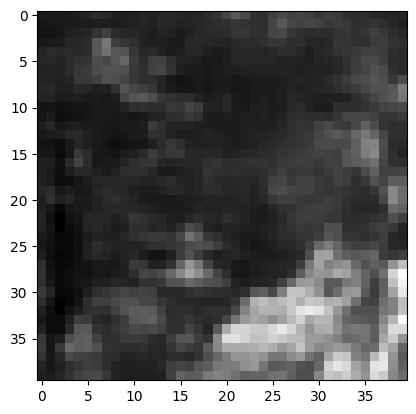

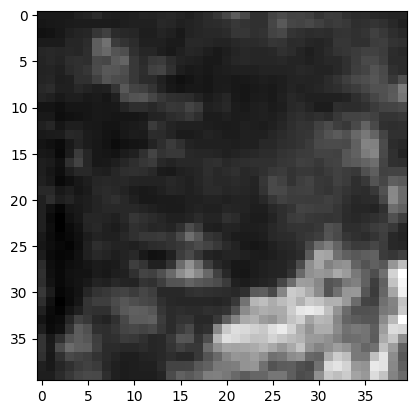

In [7]:
dd_sliced = slice_sequence(dd, 5, 40)
print("Sliced data shape: ", dd_sliced.shape)
for i in range(2):
    plt.imshow(dd_sliced[300,i])
    plt.show()

In [8]:
dd_flat = dd_sliced.reshape(dd_sliced.shape[0], -1)
print("Flattened data shape: ", dd_flat.shape)

Flattened data shape:  (81078, 8000)


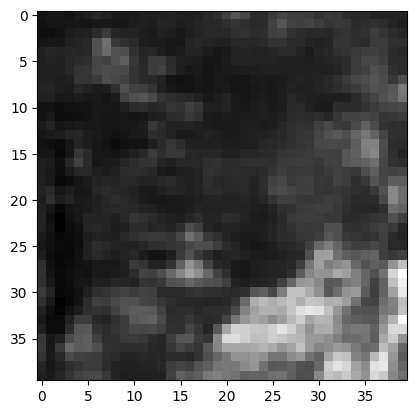

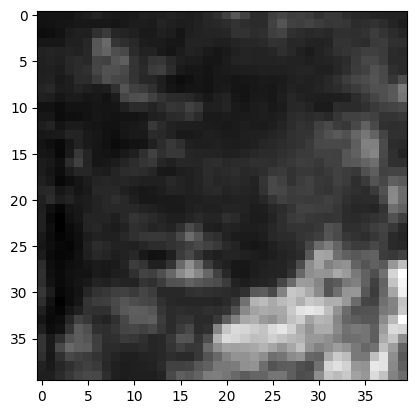

In [9]:
dd_normalized = (dd_flat - dd_flat.mean(axis=0)) / dd_flat.std(axis=0)
dd_normalized_reshaped = dd_normalized.reshape(dd_sliced.shape)

for i in range(2):
    plt.imshow(dd_normalized_reshaped[300,i])
    plt.show()

## PCA
The ZCA is closely related to the PCA. The PCA tells you the principal components, or principal directions. Let's start by calculating a PCA, and then checking a signal reconstruction from the truncated transform. Hopefuly the reader is already familiar with these concepts.

In [10]:
total_components = np.prod(dd_normalized.shape[1:])
print("Total components: ", total_components)
n_components = int(total_components * np.pi * 25 / 100)
print("Number of components: ", n_components)

Total components:  8000
Number of components:  6283


In [15]:
print("Normalized, flattened data shape: ", dd_normalized.shape)

Normalized, flattened data shape:  (81078, 8000)


Let's calculate the PCA now. The available solvers are "auto", "full", "arpack", "randomized".

The "randomized" solver is the fastest for this problem, and it's the one used by default.

The "full" solver is the slowest, but it's the only one that can be used to calculate the full PCA, not just the truncated one.

The "arpack" solver is the one that can be used to calculate the full PCA, but it's slower than "randomized".

The "auto" solver will choose between "full" and "randomized" depending on the problem size.

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=n_components,
          random_state=420, svd_solver='auto')
pca.fit(dd_normalized)

PCA(n_components=6283, random_state=420)

Let's check the "explainability" of the first n components...

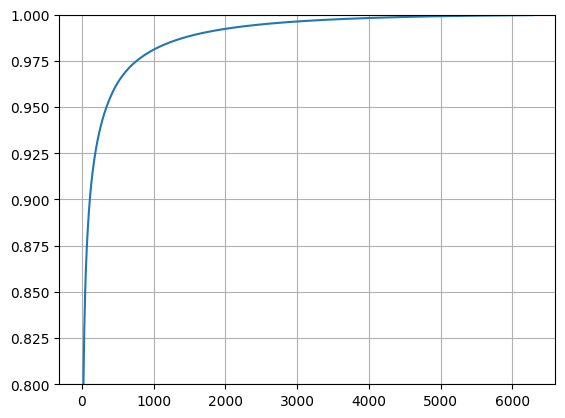

In [14]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(0.8, 1.0)
plt.grid()

The 400 components we selected give us ~97% of the "variance explanation". Notice this is just 13% of the number of components in this image (3 channels × 32 × 32 pixels). Images can really be compressed a lot!

We're now going to transform the image using the (truncated) rotation matrix the PCA gave us, then reconstruct the image back and see if there's still a cat in the bag.

In [16]:
DD = np.dot(dd_normalized - pca.mean_, pca.components_.T)

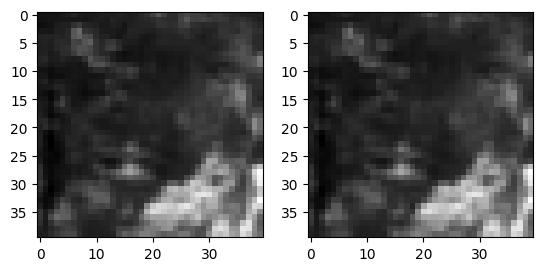

In [38]:
def reconstruct(pca, vec):
    return pca.mean_ + np.dot(vec, pca.components_)

def vtoimg(v):
     return np.array(v).reshape(5, 40, 40)
    
reconstructed = vtoimg(reconstruct(pca, DD[300]))
plt.subplot(1,2,1)
plt.imshow(dd_normalized_reshaped[300,i])
plt.subplot(1,2,2)
plt.imshow(reconstructed[0])

So we have now just picked our images, transformed them into a "shapeless" vector, applied PCA like these were datapoints from any regular classification problem like Iris, and got a basic input vector reconstruction going on. Neat.

## ZCA
Now we're going to whiten our signal. We'll just remove that silly mean, and see what's left if we remove the image auto-correlation.

In regular data, the existance of a "principal direction" found by the PCA means your data is correlated. If you rotate the data so that this direction is now an axis, you get a representation where there is no correlation anymore. And if you then appropriately rescale each of these axes, your data is now standardized/normalized/whitened.

In images, if you look for a correlation you'll most probably find auto-correlation. You'll find out each pixel of an image in a set of images is correlated to its neighboring pixels, and they are all correlated like that, relative to each other. It could be something crazy, the top left pixels negativelly correlated to the top right, and the bottom pixels with different autocorrealtion coefficients. But what you usually see, and the simplification you usually impose, is that all pixels share the same auto-correlation function across the image area.

The term "whitening" comes from time-domain processing, it referers to the fact when you remove auto-correlation from the signal, you make it more similar to "white" noise, due to the uniform power spectrum. But notice something: after you change those scales from the rotated pricipal components, the signal phase information is preserved... If you rotate you vector back, then you have a signal that is still decorrelated (distribution of the sample looks like a sphere, not an ellipsoid), but this new transformed signal is somehow as close as possible to the original signal.

Specifically for images this means two things: first you end up kind of making a high-pass filtering, like a Laplacian. Think of the image of a white disc over black background. The decorrelated version is just zero everywhere, when before you had mostly pixels with the same value of their neighbors (correlation). Now you only have pixels around the disk edge... That's where the image infromation is. And you can theoretically even reconstruct the image from this Laplacian version.

The second thing to have in mind about images, is that you also can have different channels... In that case you can also find correlations across the channels. Specially in the RGB color space, this will happen because they share a lot of the luminance information. Spaces like Lab or YUV will separate the luminance, so the correlation across these channels should be a little lower. You usually also find out chrominance channels are more auto-correlated, and for that reason you can usually downsample the chrominance.

So let's calculate some stuff now and see what all that means with graphics. Let's whiten our cat.

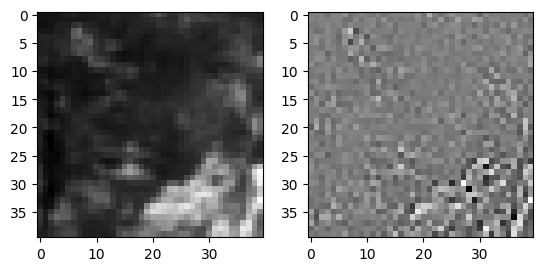

In [41]:
def whiten(pca, vec):
    QQ = np.dot(vec - pca.mean_, pca.components_.T)
    return np.dot(QQ / pca.singular_values_, pca.components_)

whitened = vtoimg(whiten(pca, dd_normalized[300]))

plt.subplot(1,2,1)
plt.imshow(dd_normalized_reshaped[300,1])
plt.subplot(1,2,2)
plt.imshow(whitened[1])

In [47]:
whitened = whiten(pca, dd_normalized)
print(whitened.shape)

(81078, 8000)


In [48]:
whitened_reshaped = whitened.reshape(-1, 5, 40, 40)

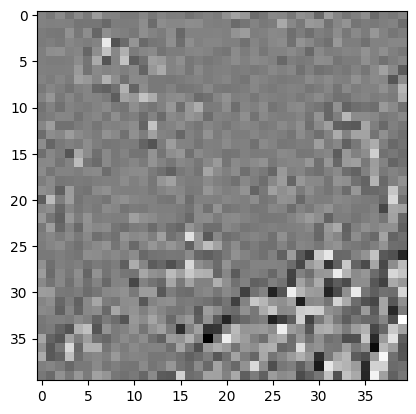

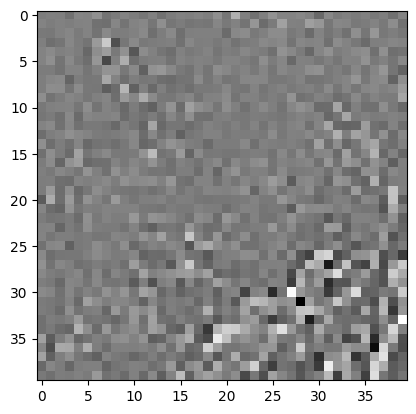

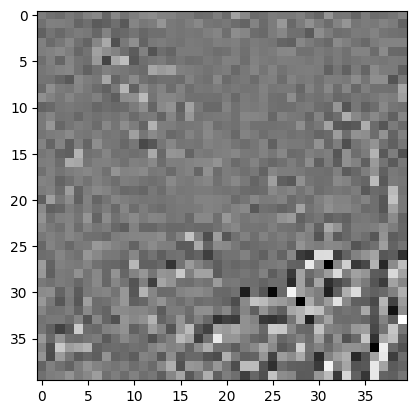

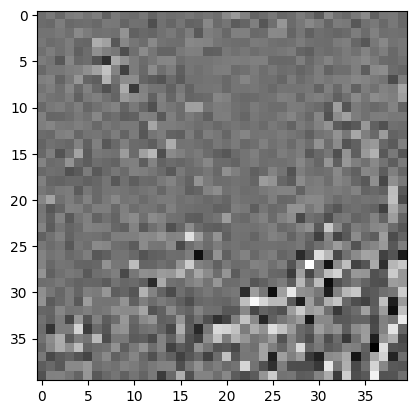

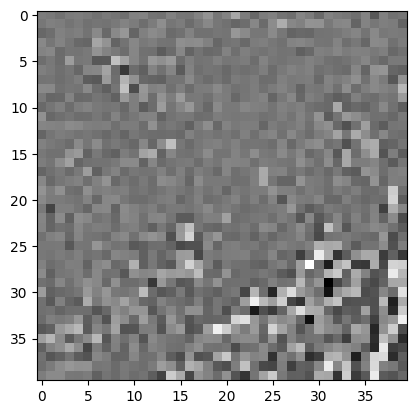

[[ 3.48147113e-04 -8.94375793e-04  9.34724935e-04 ... -3.94284602e-04
   5.03455350e-04 -3.86756039e-04]
 [-3.52573252e-04  1.24945020e-04 -2.02851209e-04 ...  4.16027924e-04
  -1.05824139e-03 -7.17281399e-04]
 [ 3.89673948e-05 -2.80878722e-04 -1.24203456e-03 ...  8.74952308e-04
  -9.57417234e-04  4.10951723e-04]
 ...
 [ 6.94987923e-04 -1.01004718e-03 -2.80797797e-03 ...  2.10701369e-03
   3.21876534e-03 -1.76494911e-03]
 [ 1.82628736e-03 -3.22703026e-04 -2.83669076e-04 ...  3.44037231e-03
   1.16766476e-03  3.64104572e-04]
 [-4.05533341e-04 -7.44513797e-04  1.70664928e-03 ...  3.88577247e-03
   1.91434065e-04 -9.67941341e-06]]


In [53]:
for i in range(5):
    plt.imshow(whitened_reshaped[300][i])
    plt.show()
print(whitened_reshaped[300, 0] - whitened_reshaped[300, 1])

In [54]:
np.save("WHITENED.npy", whitened_reshaped)

It's hard to get a feeling about what's happening, specially with the colors, but you must be able to see at least that it's a high-pass filtering effect... Let's look at more images now.

In [ ]:
plt.figure(figsize=(12,10))
for xx in range(25):
    plt.subplot(5,10,xx*2+1)
    plt.imshow(vtoimg(dd_normalized_reshaped[xx])[0])
    plt.axis('off')
    plt.subplot(5,10,xx*2+2)
    plt.imshow(vtoimg(whiten(pca, dd_normalized[xx]))[0])
    plt.axis('off')

The images look a bit noisy in part because we are not using all of the PCA components, I must say... But in general what we get are edges that somehow are also related to the peculiar colors of each object and background.

## ZCA as a linear filter

What is interesting to check now is that relation I metioned between ZCA and the Laplacian. You can usually calculate the Laplacian with a filter like

> 0 -1 0
> -1 4 -1
> 0 -1 0

Well, it turns out if you take the zca of a Dirac delta, that filter is kind of what you are going to see... And if you move the delta around, you'll see this same thing following it, so the ZCA operation kind of looks like this filter applied to the image, through convolution.

Now this is all for grayscale, but in color images you're going to see some extra correlations across channels... So it's not really a Laplacian anymore, I don't know how to call it! But let's take a look at it.

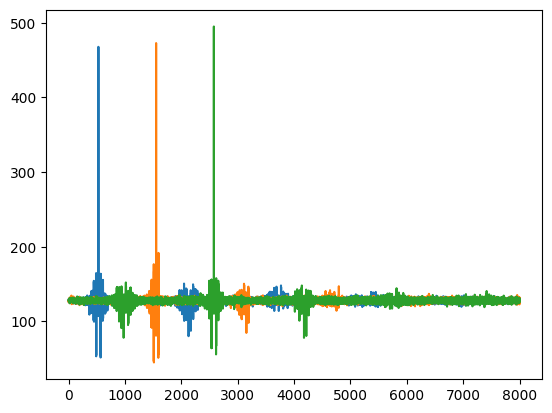

In [29]:
dirac_r = pca.mean_.copy()
dirac_g = pca.mean_.copy()
dirac_b = pca.mean_.copy()

dirac_r[32*16+16] += 1
dirac_g[32*32+32*16+16] += 1
dirac_b[2*32*32+32*16+16] += 1

plt.plot(whiten(pca, dirac_r))
plt.plot(whiten(pca, dirac_g))
plt.plot(whiten(pca, dirac_b))

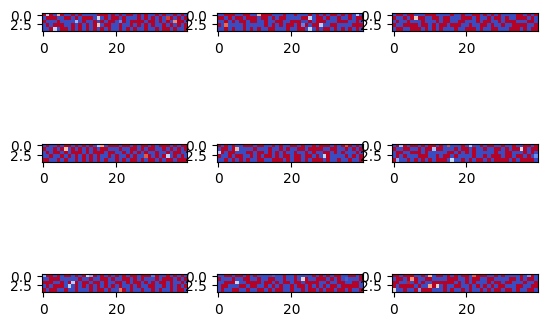

In [32]:
def vftoimg(v):
     return v.reshape(5,40,40)

kk = [dirac_r,dirac_g,dirac_b]
for k in range(3):
    for c in range(3):
        plt.subplot(3,3,c+1+k*3)
        plt.imshow(vftoimg(whiten(pca, kk[k])-128)[:,:,c], cmap=plt.cm.coolwarm, vmin=-0.1, vmax=0.1)

Let's zoom in around the impulse

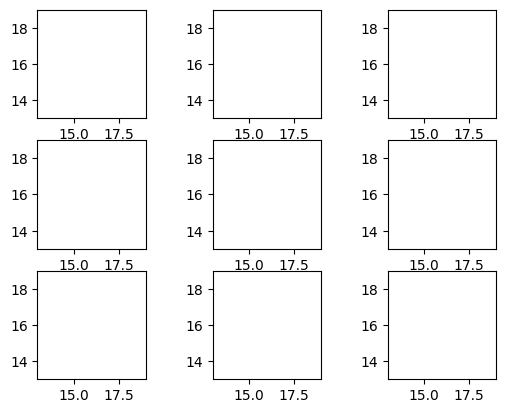

In [33]:
kk = [dirac_r,dirac_g,dirac_b]
for k in range(3):
    for c in range(3):
        plt.subplot(3,3,c+1+k*3)
        plt.imshow(vftoimg(whiten(pca, kk[k])-128)[:,:,c], cmap=plt.cm.coolwarm, vmin=-0.2, vmax=0.2)
        plt.xlim(13,19)
        plt.ylim(13,19)

In [12]:
#kk = [dirac_r,dirac_g,dirac_b]
#for k in range(3):
#    for c in range(3):
#        plt.subplot(3,3,c+1+k*3)
#        print(np.array(100*vftoimg(whiten(pca, kk[k])-128)[13:20,13:20,c], dtype=np.int))

It's not exactly a "-1 4 -1" Laplacian, but you can see the blue around the red peak, that's kind of the "mexican hat" shape we're looking for. I don't know if P.-S. de Laplace ever saw a Mexican hat in his life, but the two of them are now inextricable concepts!

## Conclusions

I hope this kernel can give you some nice coding tips, and help you think about PCA, ZCA, images, colors, correlation, but mostly this connection between the ZCA and the Laplacian, or at the very least this fact the ZCA creates this "local" linear operator, something discussed very nicely at the [famous Bell & Sejnowski article](https://www.ncbi.nlm.nih.gov/pubmed/9425547).

This tiny 5x5 filter of the ZCA, which comes from a very theoretically-important analysis procedure, looks definitely like something that could be run in the first layers of a "deep" convolutional neural network, so an open question I leave the readers is this: what happens with training if we apply this, and if we don't? Is it ever relevant? Or does a resulting model ever show some connection to it somehow? And what about Laplacian pyramids, do they ever show up in the result of a CNN? Or might there be any benefit to gain in training given the fact we know that images naturally possess these statistical characteristics? Mysteries... Hopefully nothing that can prevent us to achieve 99% accuracy in all our future projects. Happy hacking!